In [10]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE
import AE_Stats
from load_data_fn import load_data,load_data_no_filter,prep_ttbar

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib


In [5]:
n = 80

arr = torch.load('TTBAR/ttbar_1_greater_1_sim')
if n > 0:
    for i in range(n):
        arr = torch.vstack([arr,torch.load(f'TTBAR/ttbar_{int(n+2)}_greater_1_sim')])


In [77]:
t  = torch.load('TTBAR/ttbar_1_greater_1_sim')

In [7]:
print(f'There are {len(arr)} wafers with sim energy > 1 ')
print(f'mean calcq is: {torch.mean(arr[:,0:48])}')
print(f'max calcq is: {torch.max(arr[:,0:48])}')

There are 60329 wafers with sim energy > 1 
mean calcq is: 30.691824550934598
max calcq is: 10788.0


In [3]:
dt  = prep_ttbar(81)

NameError: name 'prep_ttbar' is not defined

In [46]:
mean = torch.mean(dt[:,0:48])
std =torch.std(dt[:,0:48])

In [47]:
dt_loc = torch.tensor(dt, dtype = torch.float)
dt = torch.tensor((dt[:,0:48]-mean)/std,dtype = torch.float)

/tmp/ipykernel_524/30601229.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt_loc = torch.tensor(dt, dtype = torch.float)
/tmp/ipykernel_524/30601229.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt = torch.tensor((dt[:,0:48]-mean)/std,dtype = torch.float)


tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          1.5735e+00,  2.6140e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          1.5735e+00,  2.6140e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          1.5705e+00,  2.7371e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          1.6769e+00, -5.8395e-01],
        [ 0.0000e+00,  4.4300e+02,  0.0000e+00,  ...,  1.0000e+00,
          1.6191e+00,  2.1258e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          1.6256e+00, -8.3283e-01]], dtype=torch.float64)

In [17]:
mean = torch.mean(arr[:,0:48])
std =torch.std(arr[:,0:48])

In [18]:
dt_loc = torch.tensor(arr, dtype = torch.float)
dt = torch.tensor((arr[:,0:48]-mean)/std,dtype = torch.float)


/tmp/ipykernel_238783/791336914.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt_loc = torch.tensor(arr, dtype = torch.float)
/tmp/ipykernel_238783/791336914.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt = torch.tensor((arr[:,0:48]-mean)/std,dtype = torch.float)


In [19]:
size_train =30000
size_test = 30000
train_loc = dt_loc[0:size_train]
test_loc = dt_loc[-size_test:]
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_dl_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=100,
    shuffle=False
)

test_loc_dl_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=100,
    shuffle=False
)

train = dt[0:size_train]
test = dt[-size_test:]
# train = torch.vstack([train,largest[0:1000]] )
train=train[torch.randperm(train.size()[0])]
test=test[torch.randperm(test.size()[0])]
train_dl_flat = DataLoader(
    TensorDataset(torch.Tensor(train)),
    batch_size=100,
    shuffle=False
)

test_dl_flat = DataLoader(
    TensorDataset(torch.Tensor(test)),
    batch_size=100,
    shuffle=False
)

In [12]:
def AE_MSE(data,pred):
    return torch.mean(torch.sum((data-pred)**2,dim=1))

def AE_MAE(data,pred):
    return torch.mean(torch.sum(torch.abs(data-pred),dim=1))

def weighted_AE_MSE(data, pred):
    return torch.mean(torch.sum((data[:,0:48])**2,dim=1)*torch.sum((data-pred)**2,dim=1))

def dif_weighted_AE_MSE(data, pred,alpha = 1):
    return torch.mean(((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))

def log_dif_weighted_AE_MSE(data, pred,alpha = 1):
    return torch.mean(torch.log((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))

In [23]:
def new_loss(data,pred):
    mse = AE_MSE(data,pred)
    sum_dt, sum_pred = torch.sum(data, dim=1), torch.sum(pred,dim=1)
    sum_error = torch.sum(torch.abs(sum_dt-sum_pred))
    return mse + sum_error

In [20]:
num_epochs = 50
lr = 0.0045
loss =new_loss

Epoch 0, lr 0.0045
Epoch 0: Train 39.930629361470544, Test 36.70172119140625
Epoch 1, lr 0.0045
Epoch 1: Train 31.742484798431395, Test 22.632686614990234
Epoch 2, lr 0.0045
Epoch 2: Train 23.671854610443116, Test 19.568265914916992
Epoch 3, lr 0.0045
Epoch 3: Train 16.31441708723704, Test 13.750631332397461
Epoch 4, lr 0.0045
Epoch 4: Train 11.949773306846618, Test 10.285422325134277
Epoch 5, lr 0.0045
Epoch 5: Train 9.778192776044209, Test 8.374873161315918
Epoch 6, lr 0.0045
Epoch 6: Train 8.040787499745687, Test 8.438061714172363
Epoch 7, lr 0.0045
Epoch 7: Train 7.107511518796285, Test 6.339996337890625
Epoch 8, lr 0.0045
Epoch 8: Train 7.180791506767273, Test 6.601763725280762
Epoch 9, lr 0.0045
Epoch 9: Train 6.390602010885875, Test 4.981112003326416
Epoch 10, lr 0.0045
Epoch 10: Train 5.541609286467234, Test 5.053577899932861
Epoch 11, lr 0.0045
Epoch 11: Train 5.521379353205363, Test 5.328984260559082
Epoch 12, lr 0.0045
Epoch 12: Train 5.617373301982879, Test 4.31576061248779

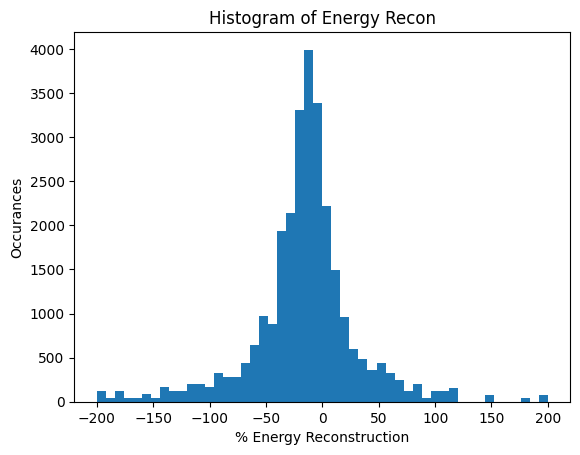

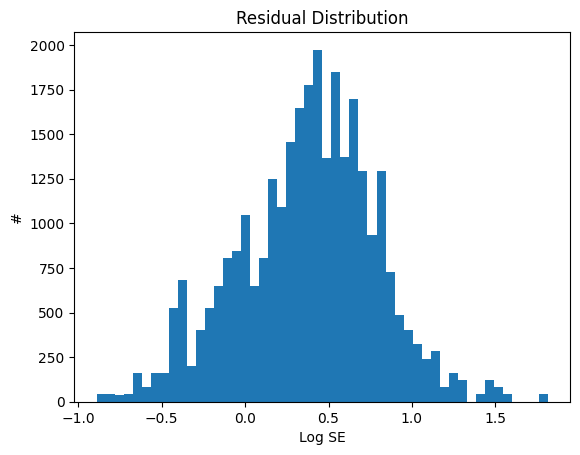

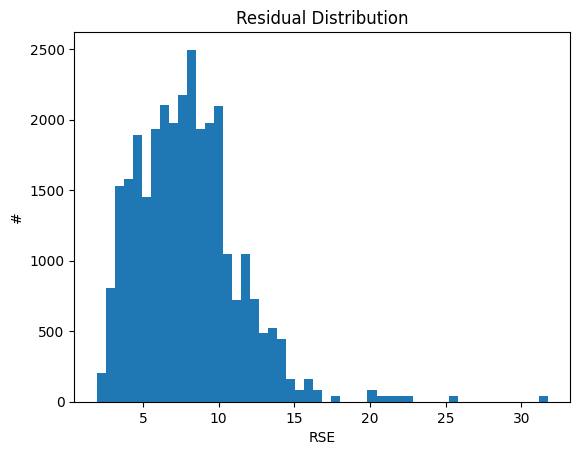

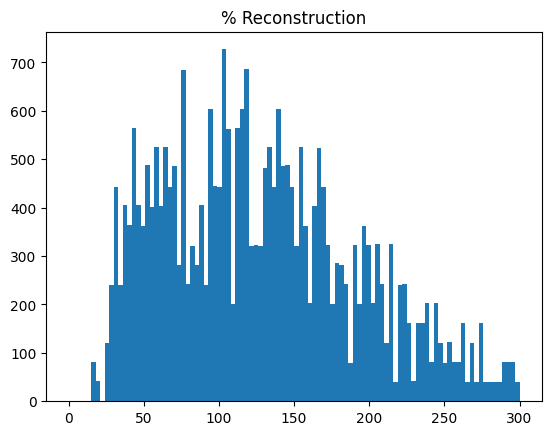

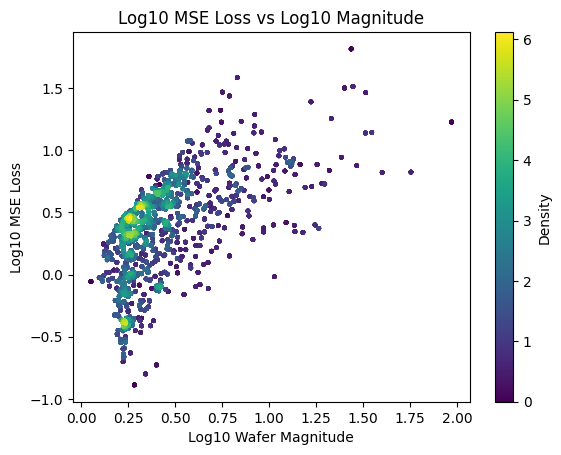

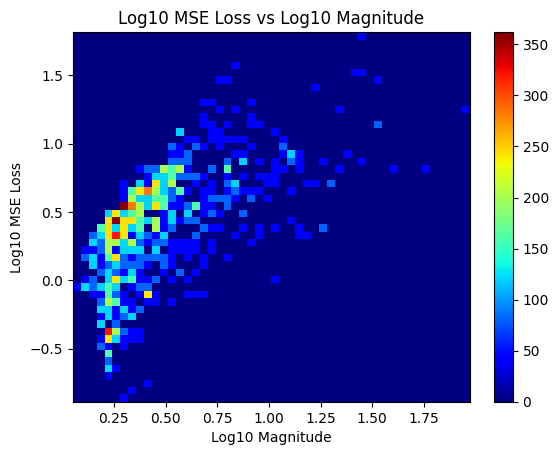

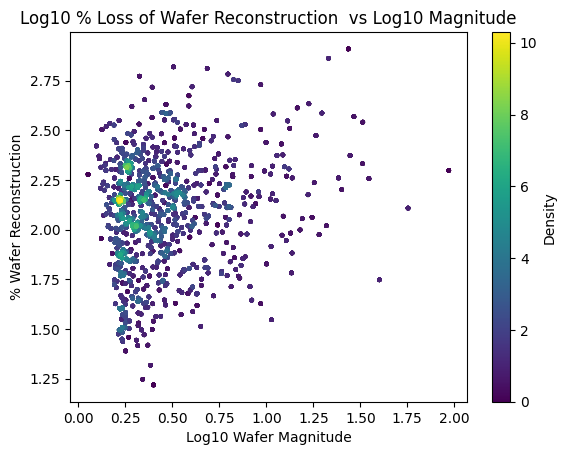

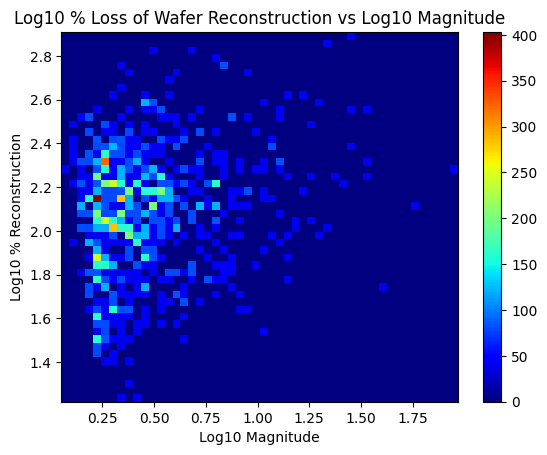

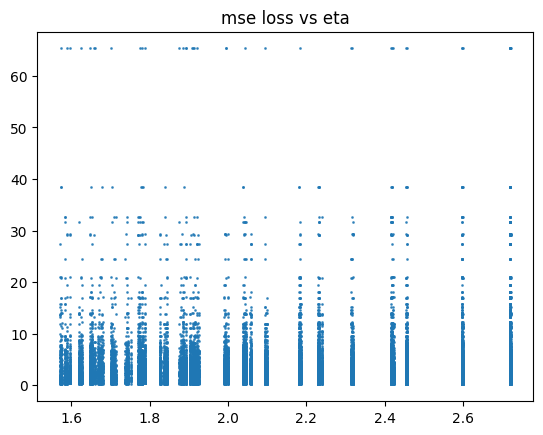

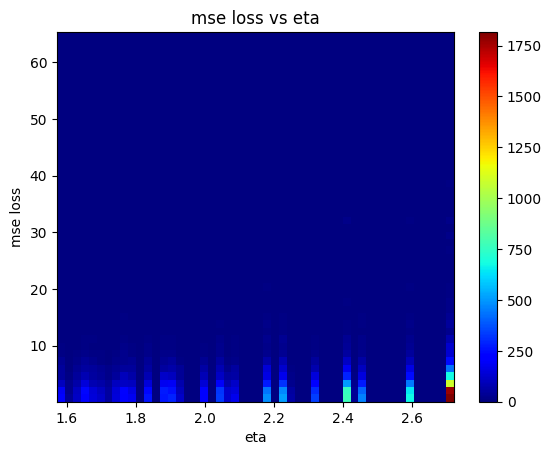

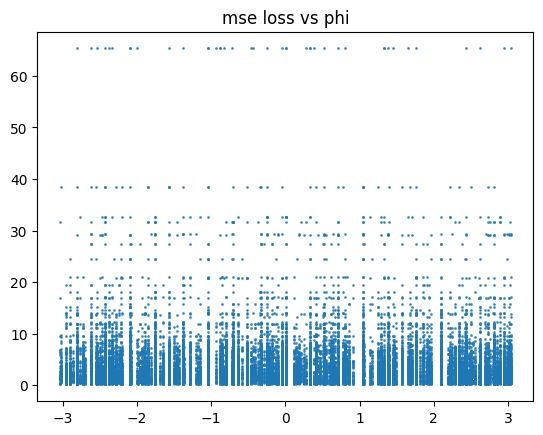

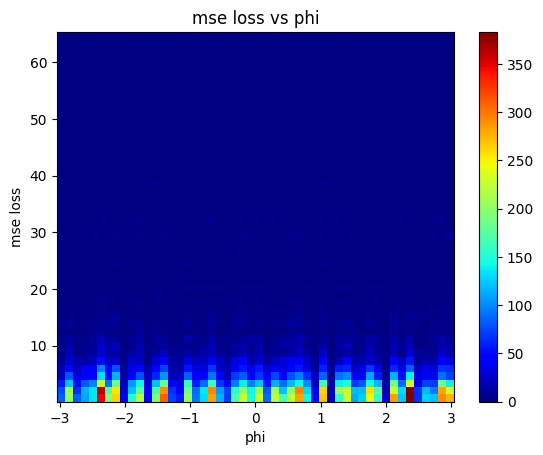

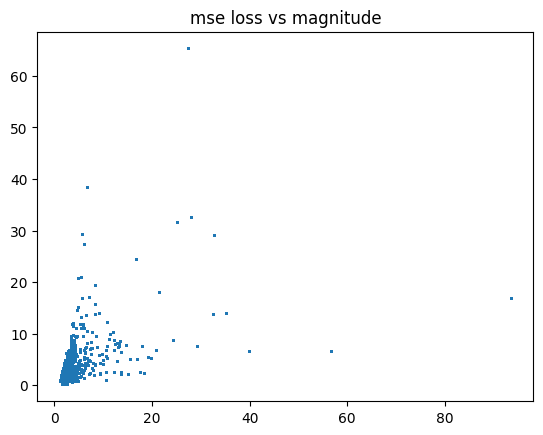

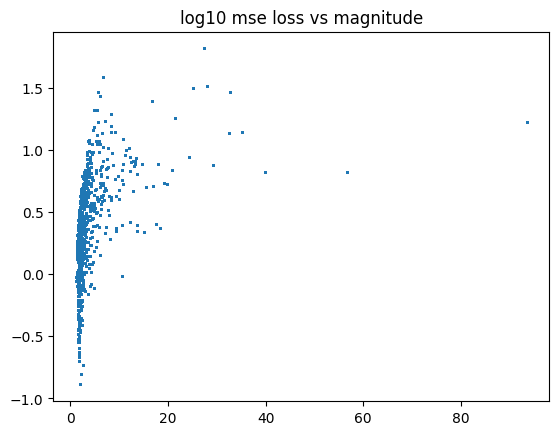

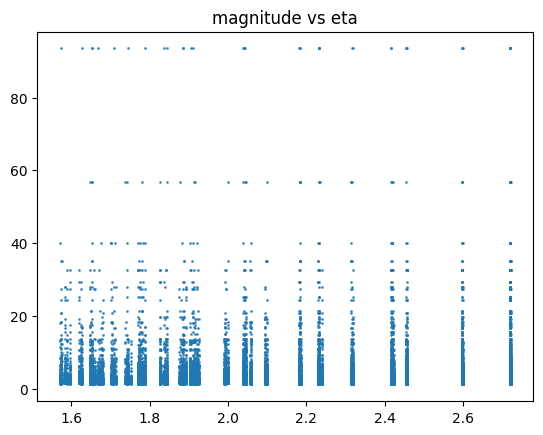

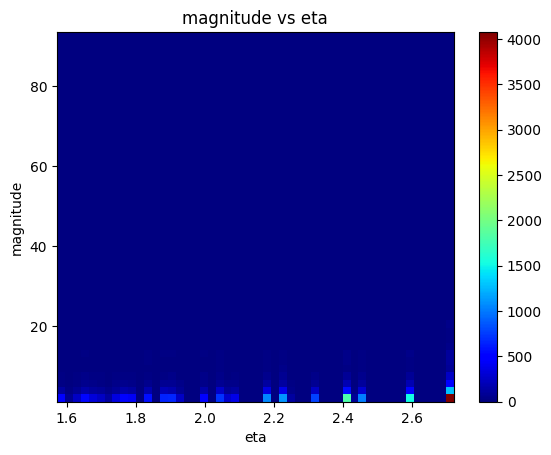

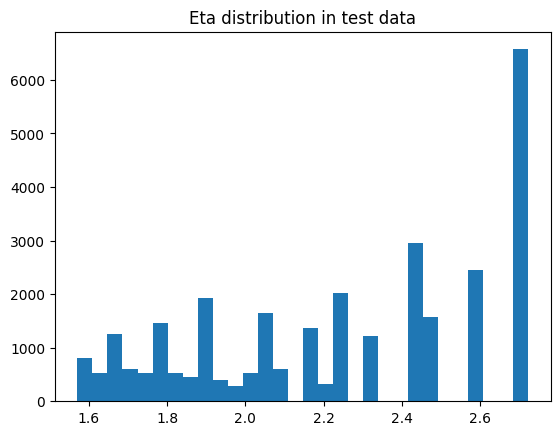

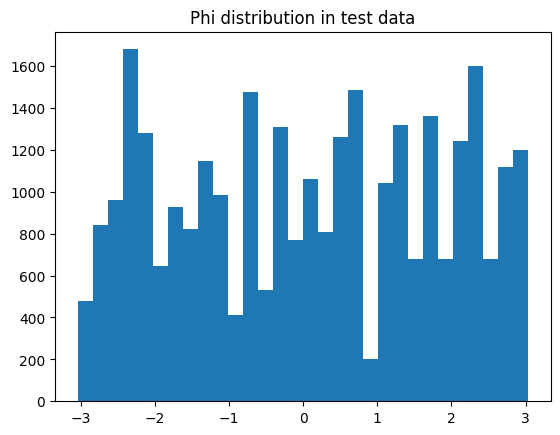

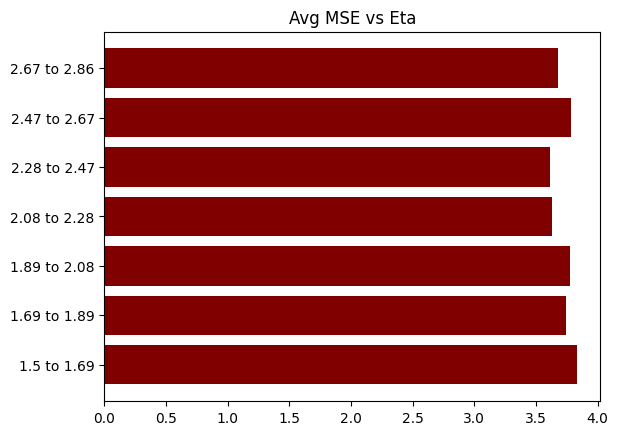

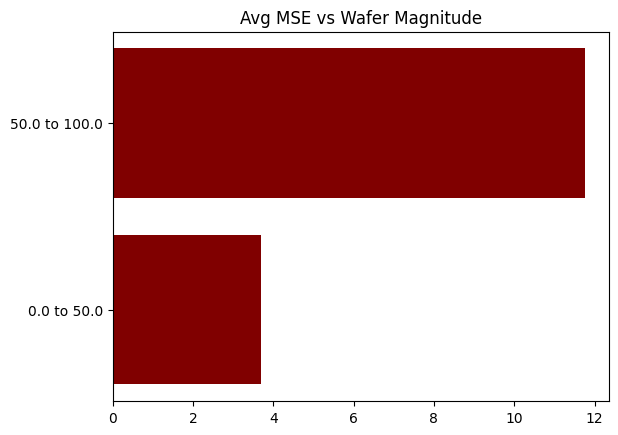

tensor([[ 2.3153, -1.0490,  4.3935,  6.0524, 11.1686],
        [ 1.7015,  0.1155,  2.5353,  1.4637,  5.9464],
        [ 2.5975, -1.0462,  2.2267,  2.8950,  8.3309],
        ...,
        [ 1.7433,  1.8553,  2.4683,  3.0152,  9.1538],
        [ 2.7208, -0.7133,  2.6555,  0.8598,  4.1777],
        [ 1.6572,  0.7056,  3.0567,  2.1048,  6.6761]], grad_fn=<CatBackward0>)

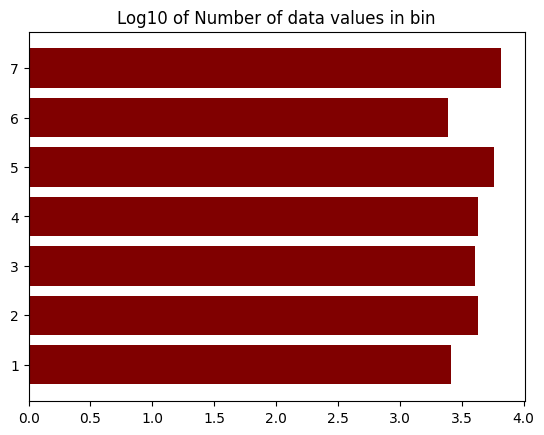

In [25]:
# fine-tune autoencoder
#batch 500


model_5 = Naive_DAE([48,250,100,16])

optimizer = optim.Adam(model_5.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)

all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, data_list in enumerate(train_dl_flat):
        model_5.train()
        data = data_list[0]
        
        v_pred = model_5(data)
        
        batch_loss = loss(data, v_pred) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_test = test
    model_5.eval()
    test_pred = model_5(data_test)
    batch_test = loss(data_test, test_pred)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
model_5.eval()
AE_Stats.gen_all_stats(model_5(test),test,test_loc)

In [ ]:
AE_Stats.gen_all_stats(model_5(dt),dt,dt_loc)